# tuning model one bagging type and other of boosting


In [4]:
# stacking performs well when different models are taken so that they capture pattern in different manner

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    PowerTransformer,
    LabelEncoder,
)
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore")

In [6]:
# !pip install optuna xgboost lightgbm mlflow dagshub

import mlflow
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

In [7]:
import dagshub

dagshub.init(repo_owner="rabin20-04", repo_name="delivery_time_prediction", mlflow=True)

Accessing as rabin20-04

Initialized MLflow to track repo "rabin20-04/delivery_time_prediction"

Repository rabin20-04/delivery_time_prediction initialized!

In [8]:
mlflow.set_tracking_uri(
    "https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow"
)

In [9]:
mlflow.set_experiment("Exp 4 - lgb tuning ")

2025/06/30 17:28:40 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4 - lgb tuning ' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/6ce8316bb0784c7791a733d1058eef3b', creation_time=1751283820629, experiment_id='3', last_update_time=1751283820629, lifecycle_stage='active', name='Exp 4 - lgb tuning ', tags={}>

In [10]:
from sklearn import set_config

set_config(transform_output="pandas")

In [11]:
df = pd.read_csv("../data/processed/cleaned_nvd.csv")
df.drop(columns="Unnamed: 0", axis=1, inplace=True)

In [12]:
X = df.drop(columns="time_taken", axis=1)
y = df["time_taken"]

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape,

((30156, 15), (7539, 15), (30156,), (7539,))

In [15]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30156 entries, 7204 to 15795
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  30156 non-null  float64
 1   ratings              30156 non-null  float64
 2   weather              30156 non-null  object 
 3   traffic              30156 non-null  object 
 4   vehicle_condition    30156 non-null  int64  
 5   type_of_order        30156 non-null  object 
 6   type_of_vehicle      30156 non-null  object 
 7   multiple_deliveries  30156 non-null  float64
 8   festival             30156 non-null  object 
 9   city_type            30156 non-null  object 
 10  is_weekend           30156 non-null  int64  
 11  pickup_time_minutes  30156 non-null  float64
 12  order_time_of_day    30156 non-null  object 
 13  distance             30156 non-null  float64
 14  distance_type        30156 non-null  object 
dtypes: float64(5), int64(2), object(8)
mem

## Preprocessing


In [16]:
num_cols = ["age", "ratings", "pickup_time_minutes", "distance"]
# continuous | categorical | nominal

nominal_cat_cols = [
    "weather",
    "type_of_order",
    "type_of_vehicle",
    "festival",
    "city_type",
    "order_time_of_day",
    "is_weekend",
]
ordinal_cat_cols = ["traffic", "distance_type"]
traffic_order = ["low", "medium", "high", "jam"]
distance_order = ["short", "medium", "long", "very_long"]

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        (
            "nominal_encode",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            nominal_cat_cols,
        ),
        (
            "ordinal_encode",
            OrdinalEncoder(categories=[traffic_order, distance_order]),
            ordinal_cat_cols,
        ),
    ],
    remainder="passthrough",
    n_jobs=3,
    verbose_feature_names_out=False,
)
preprocessor.set_output(transform="pandas")

ColumnTransformer(n_jobs=3, remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'order_time_of_day',
                                  'is_weekend']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']]),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [18]:
df

age  ratings     weather traffic  vehicle_condition type_of_order  \
0      37.0      4.9       sunny    high                  2         snack   
1      34.0      4.5      stormy     jam                  2         snack   
2      23.0      4.4  sandstorms     low                  0        drinks   
3      38.0      4.7       sunny  medium                  0        buffet   
4      32.0      4.6      cloudy    high                  1         snack   
...     ...      ...         ...     ...                ...           ...   
37690  35.0      4.2       windy     jam                  2        drinks   
37691  30.0      4.8       windy    high                  1          meal   
37692  30.0      4.9      cloudy     low                  1        drinks   
37693  20.0      4.7      cloudy    high                  0         snack   
37694  23.0      4.9         fog  medium                  2         snack   

      type_of_vehicle  multiple_deliveries festival      city_type  \
0          motorcycle                  0.0       no          urban   
1             scooter                  1.0       no  metropolitian   
2          motorcycle                  1.0       no          urban   
3          motorcycle                  1.0       no  metropolitian   
4             scooter                  1.0       no  metropolitian   
...               ...                  ...      ...            ...   
37690      motorcycle                  1.0       no  metropolitian   
37691      motorcycle                  0.0       no  metropolitian   
37692         scooter                  0.0       no  metropolitian   
37693      motorcycle                  1.0       no  metropolitian   
37694         scooter                  1.0       no  metropolitian   

       time_taken  is_weekend  pickup_time_minutes order_time_of_day  \
0              24           1                 15.0           morning   
1              33           0                  5.0           evening   
2              26           1                 15.0           morning   
3              21           0                 10.0           evening   
4              30           1                 15.0         afternoon   
...           ...         ...                  ...               ...   
37690          33           0                 10.0             night   
37691          32           0                 10.0           morning   
37692          16           0                 15.0             night   
37693          26           0                  5.0         afternoon   
37694          36           0                  5.0         afternoon   

        distance distance_type  
0       3.025149         short  
1      20.183530     very_long  
2       1.552758         short  
3       7.790401        medium  
4       6.210138        medium  
...          ...           ...  
37690  16.600272     very_long  
37691   1.489846         short  
37692   4.657195         short  
37693   6.232393        medium  
37694  12.074396          long  

[37695 rows x 16 columns]

In [19]:
X_train_trans = preprocessor.fit_transform(xtrain)
X_test_trans = preprocessor.transform(xtest)
pt = PowerTransformer()
y_train_pt = pt.fit_transform(ytrain.values.reshape(-1, 1))
y_test_pt = pt.transform(ytest.values.reshape(-1, 1))

In [20]:
X_test_trans.head()

age  ratings  pickup_time_minutes  distance  weather_fog  \
37469  0.157895     0.84                  1.0  0.239096          1.0   
33249  0.526316     0.80                  0.5  0.476360          0.0   
19970  0.368421     0.68                  0.5  0.545261          0.0   
4405   0.789474     0.96                  0.5  0.484974          1.0   
24929  0.157895     0.96                  0.5  0.623770          0.0   

       weather_sandstorms  weather_stormy  weather_sunny  weather_windy  \
37469                 0.0             0.0            0.0            0.0   
33249                 1.0             0.0            0.0            0.0   
19970                 1.0             0.0            0.0            0.0   
4405                  0.0             0.0            0.0            0.0   
24929                 1.0             0.0            0.0            0.0   

       type_of_order_drinks  ...  city_type_semi-urban  city_type_urban  \
37469                   0.0  ...                   0.0              0.0   
33249                   0.0  ...                   0.0              0.0   
19970                   0.0  ...                   0.0              0.0   
4405                    0.0  ...                   0.0              0.0   
24929                   0.0  ...                   0.0              0.0   

       order_time_of_day_evening  order_time_of_day_morning  \
37469                        0.0                        1.0   
33249                        1.0                        0.0   
19970                        1.0                        0.0   
4405                         1.0                        0.0   
24929                        0.0                        0.0   

       order_time_of_day_night  is_weekend_1  traffic  distance_type  \
37469                      0.0           0.0      2.0            1.0   
33249                      0.0           0.0      3.0            2.0   
19970                      0.0           1.0      1.0            2.0   
4405                       0.0           0.0      1.0            2.0   
24929                      0.0           1.0      1.0            2.0   

       vehicle_condition  multiple_deliveries  
37469                  0                  0.0  
33249                  2                  1.0  
19970                  0                  1.0  
4405                   0                  1.0  
24929                  0                  1.0  

[5 rows x 25 columns]

In [21]:
X_train_trans.shape

(30156, 25)

<Axes: >

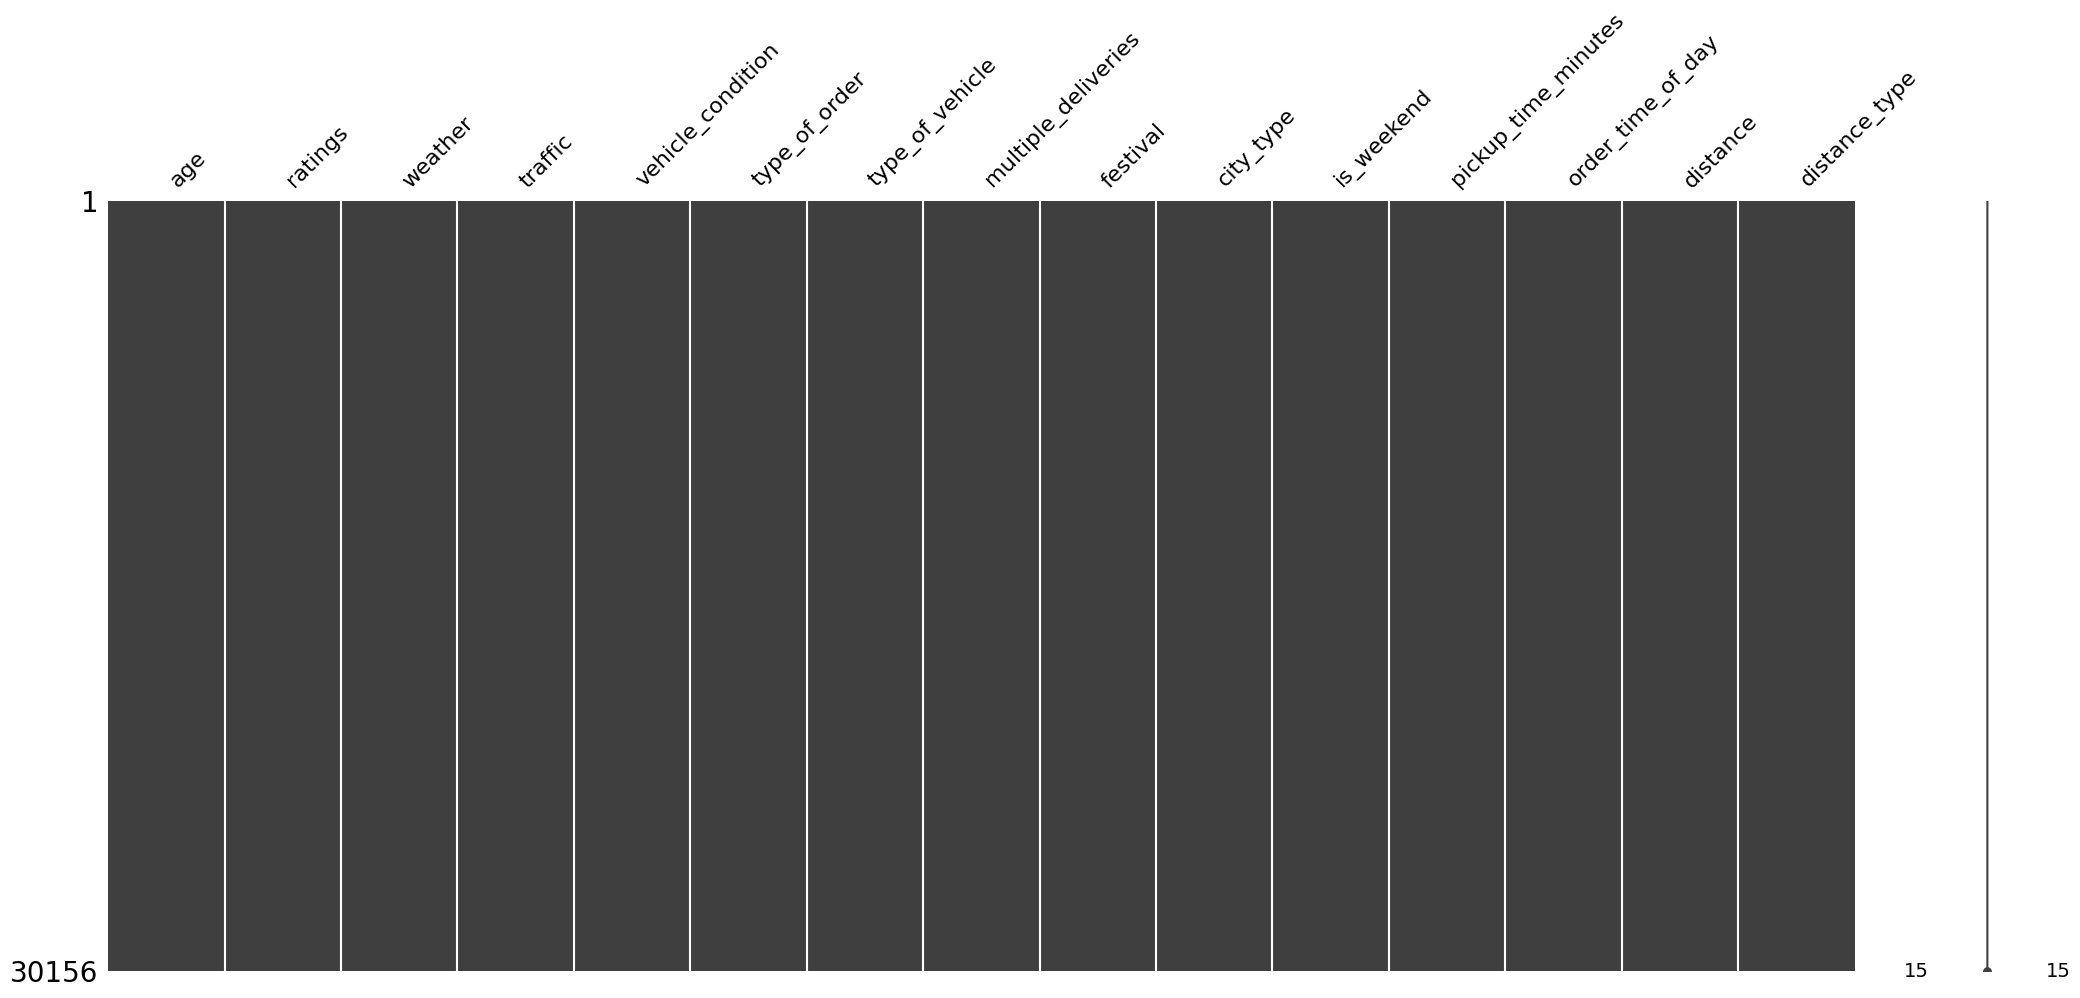

In [22]:
msno.matrix(xtrain)

## Tune


In [23]:
!pip install lightgbm optuna
from lightgbm import LGBMRegressor
import optuna

In [24]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

In [25]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators",10,200),
            "max_depth": trial.suggest_int("max_depth",1,40),
            "learning_rate": trial.suggest_float("learning_rate",0.1,0.8),
            "subsample": trial.suggest_float("subsample",0.5,1),
            "min_child_weight": trial.suggest_int("min_child_weight",5,20),
            "min_split_gain": trial.suggest_float("min_split_gain",0,10),
            "reg_lambda": trial.suggest_float("reg_lambda",0,100),
            "random_state": 42,
            "n_jobs": 4,
        }

        mlflow.log_params(params)

        lgb_reg = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=lgb_reg,transformer=pt)

        model.fit(X_train_trans,ytrain)

        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)


        cv_score = cross_val_score(model,
                                X_train_trans,
                                ytrain,
                                cv=5,
                                scoring="neg_mean_absolute_error",
                                n_jobs=4)

        mean_score = -(cv_score.mean())
        mlflow.log_metric("cross_val_error",mean_score)

        return mean_score

In [ ]:
import mlflow.sklearn


In [ ]:
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    study.optimize(objective,n_trials=50,n_jobs=4,show_progress_bar=True)

    mlflow.log_params(study.best_params)

    mlflow.log_metric("best_score",study.best_value)

    best_lgbm = LGBMRegressor(**study.best_params)

    best_lgbm.fit(X_train_trans,y_train_pt.values.ravel())

    y_pred_train = best_lgbm.predict(X_train_trans)
    y_pred_test = best_lgbm.predict(X_test_trans)

    y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))


    model = TransformedTargetRegressor(regressor=best_lgbm,
                                        transformer=pt)


    scores = cross_val_score(model,
                         X_train_trans,
                         ytrain,
                         scoring="neg_mean_absolute_error",
                         cv=5,n_jobs=4)

    mlflow.log_metric("training_error",mean_absolute_error(ytrain,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(ytest,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(ytrain,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(ytest,y_pred_test_org))
    mlflow.log_metric("cross_val",- scores.mean())

    # mlflow.sklearn.log_model(best_lgbm,artifact_path="model")

[I 2025-06-30 17:29:19,963] A new study created in memory with name: no-name-dd01f4f9-3b93-48b9-a411-fe14a887f108
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

Best trial: 0. Best value: 3.59354:   2%|▏         | 1/50 [00:12<10:32, 12.90s/it]

[I 2025-06-30 17:29:33,415] Trial 0 finished with value: 3.5935438499453314 and parameters: {'n_estimators': 131, 'max_depth': 21, 'learning_rate': 0.681524612437626, 'subsample': 0.8031029022133785, 'min_child_weight': 13, 'min_split_gain': 1.5493353197347837, 'reg_lambda': 50.209502421584894}. Best is trial 0 with value: 3.5935438499453314.
🏃 View run flawless-cow-167 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/6cb3cfaf97374b25be91465a126be177
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 0. Best value: 3.59354:   4%|▍         | 2/50 [00:14<05:11,  6.49s/it]

[I 2025-06-30 17:29:35,425] Trial 2 finished with value: 3.7331359615674997 and parameters: {'n_estimators': 105, 'max_depth': 18, 'learning_rate': 0.3086939632837784, 'subsample': 0.9796981087617098, 'min_child_weight': 9, 'min_split_gain': 8.723939681421884, 'reg_lambda': 9.386251094631993}. Best is trial 0 with value: 3.5935438499453314.
🏃 View run whimsical-tern-643 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/78ff7926d30d4b3cb24b7a85d0a81e32
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 3. Best value: 3.56641:   6%|▌         | 3/50 [00:17<03:50,  4.91s/it]

[I 2025-06-30 17:29:38,461] Trial 3 finished with value: 3.566414162998605 and parameters: {'n_estimators': 27, 'max_depth': 23, 'learning_rate': 0.11537750627605158, 'subsample': 0.8018776400929191, 'min_child_weight': 16, 'min_split_gain': 1.013940276051466, 'reg_lambda': 88.87472985401025}. Best is trial 3 with value: 3.566414162998605.


Best trial: 1. Best value: 3.30647:   8%|▊         | 4/50 [00:19<02:54,  3.78s/it]

[I 2025-06-30 17:29:40,508] Trial 1 finished with value: 3.306466477229254 and parameters: {'n_estimators': 107, 'max_depth': 21, 'learning_rate': 0.6957067557052993, 'subsample': 0.7852760064684978, 'min_child_weight': 20, 'min_split_gain': 0.10602173229318668, 'reg_lambda': 73.11977970347667}. Best is trial 1 with value: 3.306466477229254.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 1. Best value: 3.30647:  10%|█         | 5/50 [00:40<07:29,  9.99s/it]

[I 2025-06-30 17:30:01,506] Trial 4 finished with value: 3.6918056906660675 and parameters: {'n_estimators': 118, 'max_depth': 33, 'learning_rate': 0.24070607358474447, 'subsample': 0.6591779908006562, 'min_child_weight': 17, 'min_split_gain': 8.865914397539278, 'reg_lambda': 6.724088382858973}. Best is trial 1 with value: 3.306466477229254.
🏃 View run charming-snail-134 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/02fd1391a4c64f78977ed5f107239aa0
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 1. Best value: 3.30647:  12%|█▏        | 6/50 [00:42<05:18,  7.24s/it]

[I 2025-06-30 17:30:03,421] Trial 5 finished with value: 3.5853401856184783 and parameters: {'n_estimators': 172, 'max_depth': 26, 'learning_rate': 0.42637674320516483, 'subsample': 0.5519128793523865, 'min_child_weight': 6, 'min_split_gain': 3.147476216499301, 'reg_lambda': 89.49214984529866}. Best is trial 1 with value: 3.306466477229254.
🏃 View run smiling-stoat-567 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/780c98c7207a41bf86fb23d090e5aadb
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 1. Best value: 3.30647:  14%|█▍        | 7/50 [00:45<04:11,  5.86s/it]

[I 2025-06-30 17:30:06,426] Trial 6 finished with value: 3.7911101268810077 and parameters: {'n_estimators': 124, 'max_depth': 6, 'learning_rate': 0.5595054894333542, 'subsample': 0.7123607336130555, 'min_child_weight': 16, 'min_split_gain': 9.791710310754937, 'reg_lambda': 41.236749415232985}. Best is trial 1 with value: 3.306466477229254.


Best trial: 1. Best value: 3.30647:  16%|█▌        | 8/50 [00:47<03:14,  4.63s/it]

[I 2025-06-30 17:30:08,416] Trial 7 finished with value: 3.6645546358201253 and parameters: {'n_estimators': 121, 'max_depth': 16, 'learning_rate': 0.27456293496330336, 'subsample': 0.7707056003098298, 'min_child_weight': 8, 'min_split_gain': 5.15367462719106, 'reg_lambda': 83.54284560820234}. Best is trial 1 with value: 3.306466477229254.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

Best trial: 1. Best value: 3.30647:  18%|█▊        | 9/50 [01:08<06:40,  9.76s/it]

[I 2025-06-30 17:30:29,459] Trial 8 finished with value: 3.8292627088920135 and parameters: {'n_estimators': 58, 'max_depth': 17, 'learning_rate': 0.7438833706539044, 'subsample': 0.7359024776482479, 'min_child_weight': 16, 'min_split_gain': 7.684462790097432, 'reg_lambda': 59.761427327868134}. Best is trial 1 with value: 3.306466477229254.
🏃 View run capricious-jay-455 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/7ff52893e3eb49f39663ac6cfc5e9619
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 1. Best value: 3.30647:  20%|██        | 10/50 [01:10<04:55,  7.38s/it]

[I 2025-06-30 17:30:31,508] Trial 9 finished with value: 3.917530977268658 and parameters: {'n_estimators': 64, 'max_depth': 3, 'learning_rate': 0.44497466208263114, 'subsample': 0.5589753033238607, 'min_child_weight': 12, 'min_split_gain': 8.501304718932058, 'reg_lambda': 40.89582125527369}. Best is trial 1 with value: 3.306466477229254.
🏃 View run dapper-quail-40 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/5b97d20db15043798d80ff738ca135b2
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 1. Best value: 3.30647:  22%|██▏       | 11/50 [01:13<03:55,  6.03s/it]

[I 2025-06-30 17:30:34,476] Trial 10 finished with value: 3.726228423170776 and parameters: {'n_estimators': 103, 'max_depth': 27, 'learning_rate': 0.45853470513787103, 'subsample': 0.7884130389164037, 'min_child_weight': 7, 'min_split_gain': 7.818753083098738, 'reg_lambda': 8.17389983657717}. Best is trial 1 with value: 3.306466477229254.


Best trial: 1. Best value: 3.30647:  24%|██▍       | 12/50 [01:16<03:03,  4.82s/it]

[I 2025-06-30 17:30:36,525] Trial 11 finished with value: 3.4713679724802127 and parameters: {'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.2242821526656191, 'subsample': 0.7727798330798727, 'min_child_weight': 16, 'min_split_gain': 1.0826860647979242, 'reg_lambda': 25.223054284691216}. Best is trial 1 with value: 3.306466477229254.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

Best trial: 12. Best value: 3.25692:  26%|██▌       | 13/50 [01:37<05:59,  9.72s/it]

[I 2025-06-30 17:30:57,522] Trial 12 finished with value: 3.2569248839624136 and parameters: {'n_estimators': 199, 'max_depth': 36, 'learning_rate': 0.6493366139973773, 'subsample': 0.9227419920051081, 'min_child_weight': 20, 'min_split_gain': 0.05543384958826494, 'reg_lambda': 61.74574123754847}. Best is trial 12 with value: 3.2569248839624136.
🏃 View run flawless-vole-217 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/12bf56a873b44ff4925af5c2b12f49d0
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 12. Best value: 3.25692:  28%|██▊       | 14/50 [01:38<04:25,  7.37s/it]

[I 2025-06-30 17:30:59,459] Trial 13 finished with value: 3.793924957079233 and parameters: {'n_estimators': 18, 'max_depth': 39, 'learning_rate': 0.10984872095096294, 'subsample': 0.9040876402383439, 'min_child_weight': 20, 'min_split_gain': 0.02559634535733872, 'reg_lambda': 73.88340803635086}. Best is trial 12 with value: 3.2569248839624136.
🏃 View run bemused-hare-243 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/38e6c11e00ef456c937916c73e8b2ef9
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 12. Best value: 3.25692:  30%|███       | 15/50 [01:42<03:32,  6.08s/it]

[I 2025-06-30 17:31:02,549] Trial 14 finished with value: 3.339184690957211 and parameters: {'n_estimators': 69, 'max_depth': 11, 'learning_rate': 0.6017418944064219, 'subsample': 0.9167998702964664, 'min_child_weight': 20, 'min_split_gain': 0.21599843827844079, 'reg_lambda': 68.76500971473635}. Best is trial 12 with value: 3.2569248839624136.


Best trial: 15. Best value: 3.23049:  32%|███▏      | 16/50 [01:43<02:44,  4.83s/it]

[I 2025-06-30 17:31:04,478] Trial 15 finished with value: 3.2304930941883683 and parameters: {'n_estimators': 72, 'max_depth': 9, 'learning_rate': 0.586415155400763, 'subsample': 0.9019313990739353, 'min_child_weight': 20, 'min_split_gain': 0.013654097110983532, 'reg_lambda': 66.64570304778138}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Best trial: 15. Best value: 3.23049:  34%|███▍      | 17/50 [02:05<05:22,  9.76s/it]

[I 2025-06-30 17:31:25,721] Trial 16 finished with value: 3.5818040211842828 and parameters: {'n_estimators': 200, 'max_depth': 39, 'learning_rate': 0.6526016194453189, 'subsample': 0.8832223670829167, 'min_child_weight': 20, 'min_split_gain': 3.4694649186424615, 'reg_lambda': 66.784317561758}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run polite-fox-123 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/4b4477bf2027427692fc91627e6e0eb2
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  36%|███▌      | 18/50 [02:07<03:55,  7.37s/it]

[I 2025-06-30 17:31:27,524] Trial 17 finished with value: 3.6504868973891123 and parameters: {'n_estimators': 197, 'max_depth': 40, 'learning_rate': 0.7875946483402345, 'subsample': 0.8970160135846594, 'min_child_weight': 19, 'min_split_gain': 3.244145566664707, 'reg_lambda': 63.678373707150996}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run painted-quail-426 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/d0f38818ed1c45739e0c0d5cab9ee75b
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  38%|███▊      | 19/50 [02:09<03:06,  6.03s/it]

[I 2025-06-30 17:31:30,426] Trial 18 finished with value: 3.650439458087065 and parameters: {'n_estimators': 164, 'max_depth': 40, 'learning_rate': 0.5715896156727497, 'subsample': 0.8970329487989906, 'min_child_weight': 18, 'min_split_gain': 2.4590868049895076, 'reg_lambda': 54.116358097721445}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  40%|████      | 20/50 [02:11<02:24,  4.82s/it]

[I 2025-06-30 17:31:32,434] Trial 19 finished with value: 3.6919083632113496 and parameters: {'n_estimators': 189, 'max_depth': 39, 'learning_rate': 0.5616702064015565, 'subsample': 0.8775662518122509, 'min_child_weight': 18, 'min_split_gain': 2.947945870097752, 'reg_lambda': 56.55915554287223}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Best trial: 15. Best value: 3.23049:  42%|████▏     | 21/50 [02:32<04:40,  9.67s/it]

[I 2025-06-30 17:31:53,412] Trial 20 finished with value: 3.710995346861163 and parameters: {'n_estimators': 155, 'max_depth': 11, 'learning_rate': 0.5250345154570719, 'subsample': 0.9929658114496871, 'min_child_weight': 13, 'min_split_gain': 5.755212457857675, 'reg_lambda': 97.42109866088197}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run honorable-hog-251 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/649ce743dfd14189a9ee6383b95fd16e
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  44%|████▍     | 22/50 [02:34<03:26,  7.38s/it]

[I 2025-06-30 17:31:55,448] Trial 21 finished with value: 3.69170468689571 and parameters: {'n_estimators': 41, 'max_depth': 11, 'learning_rate': 0.5336667952434008, 'subsample': 0.9772289658814838, 'min_child_weight': 14, 'min_split_gain': 4.959277118342897, 'reg_lambda': 37.49322612888683}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run rebellious-moth-815 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/9d66f8474ab6407f9ad77c4940fe6a17
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  46%|████▌     | 23/50 [02:38<02:44,  6.09s/it]

[I 2025-06-30 17:31:58,543] Trial 22 finished with value: 3.647507080055953 and parameters: {'n_estimators': 149, 'max_depth': 11, 'learning_rate': 0.49796119848782805, 'subsample': 0.9703773058036739, 'min_child_weight': 14, 'min_split_gain': 4.907841030541537, 'reg_lambda': 99.82656485989204}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  48%|████▊     | 24/50 [02:39<02:06,  4.85s/it]

[I 2025-06-30 17:32:00,488] Trial 23 finished with value: 3.6631632553234743 and parameters: {'n_estimators': 146, 'max_depth': 11, 'learning_rate': 0.5068445515789028, 'subsample': 0.9853343800900685, 'min_child_weight': 13, 'min_split_gain': 4.8492140433182085, 'reg_lambda': 98.24676297906665}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

Best trial: 15. Best value: 3.23049:  50%|█████     | 25/50 [03:00<04:01,  9.68s/it]

[I 2025-06-30 17:32:21,431] Trial 24 finished with value: 3.59639476329633 and parameters: {'n_estimators': 89, 'max_depth': 32, 'learning_rate': 0.6966372405893749, 'subsample': 0.8508590758888579, 'min_child_weight': 18, 'min_split_gain': 2.0254875147102047, 'reg_lambda': 76.00097782230606}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run vaunted-fowl-70 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/898aac79b48e4da8b5cc351323940596
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  52%|█████▏    | 26/50 [03:02<02:56,  7.37s/it]

[I 2025-06-30 17:32:23,416] Trial 25 finished with value: 3.5365653593189337 and parameters: {'n_estimators': 93, 'max_depth': 33, 'learning_rate': 0.6854211890672162, 'subsample': 0.6549943364289611, 'min_child_weight': 18, 'min_split_gain': 1.8028663600251202, 'reg_lambda': 75.43187303055663}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run resilient-panda-169 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/5ff7bc9d32034bcba27cb05b058bd1d0
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  54%|█████▍    | 27/50 [03:05<02:19,  6.06s/it]

[I 2025-06-30 17:32:26,416] Trial 26 finished with value: 3.560337216174586 and parameters: {'n_estimators': 97, 'max_depth': 33, 'learning_rate': 0.6757838516143011, 'subsample': 0.8382026408205063, 'min_child_weight': 18, 'min_split_gain': 1.8201375815466387, 'reg_lambda': 80.29328661045129}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  56%|█████▌    | 28/50 [03:07<01:46,  4.84s/it]

[I 2025-06-30 17:32:28,419] Trial 27 finished with value: 3.5603300605485364 and parameters: {'n_estimators': 84, 'max_depth': 32, 'learning_rate': 0.6872230880938316, 'subsample': 0.8407669850074807, 'min_child_weight': 18, 'min_split_gain': 2.003480795009241, 'reg_lambda': 77.90685097993878}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Best trial: 15. Best value: 3.23049:  58%|█████▊    | 29/50 [03:28<03:23,  9.69s/it]

[I 2025-06-30 17:32:49,437] Trial 28 finished with value: 4.302498186448262 and parameters: {'n_estimators': 45, 'max_depth': 1, 'learning_rate': 0.6216915864693918, 'subsample': 0.8425581427251929, 'min_child_weight': 11, 'min_split_gain': 0.7249378799389239, 'reg_lambda': 46.71452603670827}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run hilarious-goose-750 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/6096e5a773db4d95bfb20c0540dbbba3
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  60%|██████    | 30/50 [03:30<02:27,  7.38s/it]

[I 2025-06-30 17:32:51,419] Trial 29 finished with value: 3.4237798467052327 and parameters: {'n_estimators': 46, 'max_depth': 29, 'learning_rate': 0.6124390728723672, 'subsample': 0.9361953667675654, 'min_child_weight': 11, 'min_split_gain': 0.7061392299492739, 'reg_lambda': 47.814387529202776}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run fortunate-robin-314 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/df723b7413fa4d64b7b151d5d1df56cd
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  62%|██████▏   | 31/50 [03:33<01:55,  6.07s/it]

[I 2025-06-30 17:32:54,419] Trial 30 finished with value: 3.4041224653996323 and parameters: {'n_estimators': 179, 'max_depth': 28, 'learning_rate': 0.7755967367019059, 'subsample': 0.9506342079608127, 'min_child_weight': 10, 'min_split_gain': 0.7654783269133552, 'reg_lambda': 47.53683091848779}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  64%|██████▍   | 32/50 [03:35<01:27,  4.85s/it]

[I 2025-06-30 17:32:56,426] Trial 31 finished with value: 3.391513994092912 and parameters: {'n_estimators': 48, 'max_depth': 28, 'learning_rate': 0.6327832147979254, 'subsample': 0.9297537132964667, 'min_child_weight': 11, 'min_split_gain': 0.5638984242484915, 'reg_lambda': 68.2600608288084}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

Best trial: 15. Best value: 3.23049:  66%|██████▌   | 33/50 [03:56<02:44,  9.69s/it]

[I 2025-06-30 17:33:17,418] Trial 32 finished with value: 3.6219168207967187 and parameters: {'n_estimators': 140, 'max_depth': 22, 'learning_rate': 0.7722636845059455, 'subsample': 0.945084140922436, 'min_child_weight': 20, 'min_split_gain': 3.785528706766623, 'reg_lambda': 68.16942064856818}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  68%|██████▊   | 34/50 [03:57<01:53,  7.08s/it]

[I 2025-06-30 17:33:18,419] Trial 33 finished with value: 3.2949571341388535 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.7326172524269505, 'subsample': 0.9262106719671339, 'min_child_weight': 20, 'min_split_gain': 0.09050013616546071, 'reg_lambda': 68.25406717864342}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run legendary-pig-445 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/66992bbf36b54031a95dc39c3447b54d
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3
🏃 View run efficient-shrew-571 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/411a4f5e505e495095ce18987ebd8865
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  70%|███████   | 35/50 [04:03<01:39,  6.64s/it]

[I 2025-06-30 17:33:24,036] Trial 34 finished with value: 3.290823681141204 and parameters: {'n_estimators': 136, 'max_depth': 8, 'learning_rate': 0.7273930425850484, 'subsample': 0.9286076991282735, 'min_child_weight': 20, 'min_split_gain': 0.12237943727224646, 'reg_lambda': 65.91929146501806}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  72%|███████▏  | 36/50 [04:03<01:06,  4.78s/it]

[I 2025-06-30 17:33:24,449] Trial 35 finished with value: 3.2769522426683864 and parameters: {'n_estimators': 73, 'max_depth': 8, 'learning_rate': 0.7339195088723628, 'subsample': 0.9312810135209852, 'min_child_weight': 20, 'min_split_gain': 0.06658100472983733, 'reg_lambda': 69.25550352208633}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] St

Best trial: 15. Best value: 3.23049:  74%|███████▍  | 37/50 [04:24<02:05,  9.63s/it]

[I 2025-06-30 17:33:45,419] Trial 36 finished with value: 3.246117705358273 and parameters: {'n_estimators': 79, 'max_depth': 14, 'learning_rate': 0.7263987843561537, 'subsample': 0.8235164264339996, 'min_child_weight': 19, 'min_split_gain': 0.013499462064245016, 'reg_lambda': 59.523601264569876}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  76%|███████▌  | 38/50 [04:25<01:24,  7.05s/it]

[I 2025-06-30 17:33:46,433] Trial 37 finished with value: 3.5150665447124205 and parameters: {'n_estimators': 80, 'max_depth': 14, 'learning_rate': 0.7288799678185689, 'subsample': 0.8188068198665812, 'min_child_weight': 19, 'min_split_gain': 1.2260692715769115, 'reg_lambda': 86.08791839175288}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run tasteful-hog-475 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/4169bdf1710e401e9c6eebdde38a6222
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3
🏃 View run gentle-dove-134 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/7d214c6c844c45efbe3b1d206a505c4d
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  78%|███████▊  | 39/50 [04:30<01:10,  6.43s/it]

[I 2025-06-30 17:33:51,428] Trial 38 finished with value: 3.5048592488739816 and parameters: {'n_estimators': 108, 'max_depth': 8, 'learning_rate': 0.7345925184993928, 'subsample': 0.865878322408156, 'min_child_weight': 19, 'min_split_gain': 1.3436280558793863, 'reg_lambda': 59.41947718865164}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  80%|████████  | 40/50 [04:31<00:47,  4.80s/it]

[I 2025-06-30 17:33:52,418] Trial 39 finished with value: 3.613643873315096 and parameters: {'n_estimators': 78, 'max_depth': 8, 'learning_rate': 0.7304148988742613, 'subsample': 0.8646071848154561, 'min_child_weight': 19, 'min_split_gain': 1.4814108452311465, 'reg_lambda': 60.68597965031348}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 15. Best value: 3.23049:  82%|████████▏ | 41/50 [04:52<01:26,  9.66s/it]

[I 2025-06-30 17:34:13,425] Trial 40 finished with value: 3.5977660309598685 and parameters: {'n_estimators': 113, 'max_depth': 20, 'learning_rate': 0.5841118592617534, 'subsample': 0.8676377419218828, 'min_child_weight': 19, 'min_split_gain': 1.3975135177428673, 'reg_lambda': 58.39280666453593}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  84%|████████▍ | 42/50 [04:53<00:56,  7.06s/it]

[I 2025-06-30 17:34:14,417] Trial 41 finished with value: 3.458982149047338 and parameters: {'n_estimators': 112, 'max_depth': 19, 'learning_rate': 0.3877421199011246, 'subsample': 0.8117795873057267, 'min_child_weight': 19, 'min_split_gain': 1.347882261998711, 'reg_lambda': 59.92716067602507}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run kindly-stag-202 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/173c9925f07c4a989d97d5f4d81f7ecd
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3
🏃 View run angry-snake-521 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/c6fddc7fa36b4a32ad729c16ca5f554c
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  86%|████████▌ | 43/50 [04:58<00:45,  6.45s/it]

[I 2025-06-30 17:34:19,446] Trial 42 finished with value: 3.569974723664372 and parameters: {'n_estimators': 58, 'max_depth': 19, 'learning_rate': 0.6593510247820024, 'subsample': 0.8148513460525446, 'min_child_weight': 17, 'min_split_gain': 2.5281665098050436, 'reg_lambda': 52.61664256379375}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  88%|████████▊ | 44/50 [04:59<00:28,  4.82s/it]

[I 2025-06-30 17:34:20,468] Trial 43 finished with value: 3.5611871795685666 and parameters: {'n_estimators': 56, 'max_depth': 19, 'learning_rate': 0.6593701765389576, 'subsample': 0.814684542040596, 'min_child_weight': 17, 'min_split_gain': 2.516117357762598, 'reg_lambda': 34.19991331456801}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 15. Best value: 3.23049:  90%|█████████ | 45/50 [05:20<00:48,  9.66s/it]

[I 2025-06-30 17:34:41,423] Trial 44 finished with value: 3.3325216855779765 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.6711817720178207, 'subsample': 0.9553275426212833, 'min_child_weight': 17, 'min_split_gain': 0.41393480296682594, 'reg_lambda': 52.540544227858554}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  92%|█████████▏| 46/50 [05:21<00:28,  7.08s/it]

[I 2025-06-30 17:34:42,486] Trial 45 finished with value: 3.4253496468753433 and parameters: {'n_estimators': 134, 'max_depth': 8, 'learning_rate': 0.7999830115290371, 'subsample': 0.9545891749113689, 'min_child_weight': 17, 'min_split_gain': 0.4153090127829385, 'reg_lambda': 52.002494920249624}. Best is trial 15 with value: 3.2304930941883683.
🏃 View run chill-seal-880 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/348c5efd656c46ad87ae9f8ccac2f8b0
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3
🏃 View run bright-koi-884 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/31faebd9d88f4c2596af1cf27d0d53d1
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


Best trial: 15. Best value: 3.23049:  94%|█████████▍| 47/50 [05:26<00:19,  6.47s/it]

[I 2025-06-30 17:34:47,511] Trial 46 finished with value: 3.3975819417938835 and parameters: {'n_estimators': 130, 'max_depth': 8, 'learning_rate': 0.7071141055313919, 'subsample': 0.9615675352395694, 'min_child_weight': 15, 'min_split_gain': 0.37538721241283746, 'reg_lambda': 72.27965546032951}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049:  96%|█████████▌| 48/50 [05:28<00:09,  4.83s/it]

[I 2025-06-30 17:34:48,534] Trial 47 finished with value: 3.339995304631651 and parameters: {'n_estimators': 99, 'max_depth': 7, 'learning_rate': 0.7094824534416664, 'subsample': 0.9571255584008265, 'min_child_weight': 15, 'min_split_gain': 0.4054877743202563, 'reg_lambda': 0.8933883507447078}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Best trial: 15. Best value: 3.23049:  98%|█████████▊| 49/50 [05:38<00:06,  6.67s/it]

[I 2025-06-30 17:34:59,486] Trial 48 finished with value: 3.281453196917861 and parameters: {'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.7587522763004745, 'subsample': 0.9132782695028872, 'min_child_weight': 15, 'min_split_gain': 0.007721446007458811, 'reg_lambda': 72.13563704242124}. Best is trial 15 with value: 3.2304930941883683.


Best trial: 15. Best value: 3.23049: 100%|██████████| 50/50 [05:39<00:00,  6.80s/it]


[I 2025-06-30 17:35:00,509] Trial 49 finished with value: 3.23623876458838 and parameters: {'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.7156054993042429, 'subsample': 0.9126310198938986, 'min_child_weight': 15, 'min_split_gain': 0.002866768372489715, 'reg_lambda': 71.66786555819267}. Best is trial 15 with value: 3.2304930941883683.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirem

2025/06/30 17:35:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run best_model at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3/runs/c66c5e5b83d84b43ace5fcd389812cdb
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/3


RestException: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}

In [27]:
study.best_params

{'n_estimators': 72,
 'max_depth': 9,
 'learning_rate': 0.586415155400763,
 'subsample': 0.9019313990739353,
 'min_child_weight': 20,
 'min_split_gain': 0.013654097110983532,
 'reg_lambda': 66.64570304778138}

In [28]:
study.best_value

3.2304930941883683

In [29]:

optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [3.5935438499453314, 3.306466477229254, 3.7331359615674997,
                    3.566414162998605, 3.6918056906660675, 3.5853401856184783,
                    3.7911101268810077, 3.6645546358201253, 3.8292627088920135,
                    3.917530977268658, 3.726228423170776, 3.4713679724802127,
                    3.2569248839624136, 3.793924957079233, 3.339184690957211,
                    3.2304930941883683, 3.5818040211842828, 3.6504868973891123,
                    3.650439458087065, 3.6919083632113496, 3.710995346861163,
                    3.69170468689571, 3.647507080055953, 3.6631632553234743,
                    3.59639476329633, 3.5365653593189337, 3.560337216174586,
                    3.5603300605485364, 4.302498186448262, 3.4237798467052327,
                    3.4041224653996323, 3.391513994092912, 3.6219168207967187,
                    3.2949571341388535, 3.290823681141204, 3.2769522426683864,
                    3.246117705358273, 3.5150665447124205, 3.5048592488739816,
                    3.613643873315096, 3.5977660309598685, 3.458982149047338,
                    3.569974723664372, 3.5611871795685666, 3.3325216855779765,
                    3.4253496468753433, 3.3975819417938835, 3.339995304631651,
                    3.281453196917861, 3.23623876458838]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [3.5935438499453314, 3.306466477229254, 3.306466477229254,
                    3.306466477229254, 3.306466477229254, 3.306466477229254,
                    3.306466477229254, 3.306466477229254, 3.306466477229254,
                    3.306466477229254, 3.306466477229254, 3.306466477229254,
                    3.2569248839624136, 3.2569248839624136, 3.2569248839624136,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683, 3.2304930941883683,
                    3.2304930941883683, 3.2304930941883683]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [30]:

optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [min_child_weight (IntDistribution):
                                0.0051046420249631535<extra></extra>, reg_lambda
                                (FloatDistribution):
                                0.008746233574275706<extra></extra>, subsample
                                (FloatDistribution):
                                0.016498302564019195<extra></extra>, n_estimators
                                (IntDistribution):
                                0.02433907086556792<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.02617244181006004<extra></extra>, max_depth
                                (IntDistribution):
                                0.3190656381659895<extra></extra>, min_split_gain
                                (FloatDistribution):
                                0.6000736709951247<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, 0.02, 0.02, 0.03, 0.32, 0.60],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0051046420249631535, 0.008746233574275706,
                    0.016498302564019195, 0.02433907086556792, 0.02617244181006004,
                    0.3190656381659895, 0.6000736709951247],
              'y': [min_child_weight, reg_lambda, subsample, n_estimators,
                    learning_rate, max_depth, min_split_gain]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [31]:
# slice plot

optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.681524612437626, 0.6957067557052993, 0.3086939632837784,
                    0.11537750627605158, 0.24070607358474447, 0.42637674320516483,
                    0.5595054894333542, 0.27456293496330336, 0.7438833706539044,
                    0.44497466208263114, 0.45853470513787103, 0.2242821526656191,
                    0.6493366139973773, 0.10984872095096294, 0.6017418944064219,
                    0.586415155400763, 0.6526016194453189, 0.7875946483402345,
                    0.5715896156727497, 0.5616702064015565, 0.5250345154570719,
                    0.5336667952434008, 0.49796119848782805, 0.5068445515789028,
                    0.6966372405893749, 0.6854211890672162, 0.6757838516143011,
                    0.6872230880938316, 0.6216915864693918, 0.6124390728723672,
                    0.7755967367019059, 0.6327832147979254, 0.7722636845059455,
                    0.7326172524269505, 0.7273930425850484, 0.7339195088723628,
                    0.7263987843561537, 0.7288799678185689, 0.7345925184993928,
                    0.7304148988742613, 0.5841118592617534, 0.3877421199011246,
                    0.6593510247820024, 0.6593701765389576, 0.6711817720178207,
                    0.7999830115290371, 0.7071141055313919, 0.7094824534416664,
                    0.7587522763004745, 0.7156054993042429],
              'xaxis': 'x',
              'y': [3.5935438499453314, 3.306466477229254, 3.7331359615674997,
                    3.566414162998605, 3.6918056906660675, 3.5853401856184783,
                    3.7911101268810077, 3.6645546358201253, 3.8292627088920135,
                    3.917530977268658, 3.726228423170776, 3.4713679724802127,
                    3.2569248839624136, 3.793924957079233, 3.339184690957211,
                    3.2304930941883683, 3.5818040211842828, 3.6504868973891123,
                    3.650439458087065, 3.6919083632113496, 3.710995346861163,
                    3.69170468689571, 3.647507080055953, 3.6631632553234743,
                    3.59639476329633, 3.5365653593189337, 3.560337216174586,
                    3.5603300605485364, 4.302498186448262, 3.4237798467052327,
                    3.4041224653996323, 3.391513994092912, 3.6219168207967187,
                    3.2949571341388535, 3.290823681141204, 3.2769522426683864,
                    3.246117705358273, 3.5150665447124205, 3.5048592488739816,
                    3.613643873315096, 3.5977660309598685, 3.458982149047338,
                    3.569974723664372, 3.5611871795685666, 3.3325216855779765,
                    3.4253496468753433, 3.3975819417938835, 3.339995304631651,
                    3.281453196917861, 3.23623876458838],
              'yaxis': 'y'},
             {'marker': {'color':